In [1]:
import polars as pl
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Utils

Please refer to the function's doc string to understand its functioning.

In [2]:
def lagged_table(df, n_lag):
    
    """
    Create a lagged feature table by generating lagged versions of each column in the dataframe, 
    excluding the 'client_id', 'period', and 'category' columns. The function returns a new dataframe 
    that includes these lagged features, where each lagged column is shifted by 1 to n_lag periods.

    Parameters:
    -----------
    df: DataFrame
        The input dataframe containing the original features. It must contain 'client_id' and 'period' columns.
    n_lag: int
        The number of lagged periods to create for each feature.

    Returns:
    --------
    DataFrame
        A new dataframe with the original 'client_id' and 'period' columns, and additional columns for each 
        lagged feature. Rows with missing values generated by the lagging process are dropped.
    """

    lag_columns = []
    
    cols = [col for col in df.columns if col != 'client_id' and col != 'period' and col != 'category']
    
    for i in range(1, n_lag+1):
        
        for col in cols: 

            lag_columns.append(df[col].shift(i).alias(f'{col}_t-{i}'))
    
    lag_columns.append(df['repays_debt'].shift(-2).alias('repays_debt_t+2'))
            
    df = df.with_columns(['period', 'client_id'] + lag_columns)
    df = df.filter(pl.col('period') > n_lag)
    
    return df.drop_nulls()

# Filter by removing people that always paid back

Import the subsampled data, previously obtained and saved in the notebook **reduced_df**.

In [3]:
reduced_df = pl.read_csv('Data/average_repaying.csv')

Filter by retaining in the training set only the `client_id` that are present in **reduced_df**.

In [4]:
df_train = pl.read_csv('Data/training.csv')
df_train = df_train.filter(pl.col('client_id').is_in(reduced_df['client_id']))

The `category` variable has a numerical encoding, and we believe it is better to OneHot encode this, by creating three dummy variables and then removing one of them, to avoid perfect collinearity.

In [5]:
encoded_category = df_train['category'].to_dummies(drop_first = True)
df_train = pl.concat([df_train, encoded_category], how = 'horizontal')

Apply the function defined above.

In [6]:
lag_df = lagged_table(df_train, 2)

In [7]:
lag_df = lag_df.filter(pl.col('period')<19)

Let's see the class imbalance.

In [8]:
lag_df['repays_debt'].value_counts()

repays_debt,count
i64,u32
0,12591
1,5521


In [9]:
pd.DataFrame(lag_df, columns=lag_df.columns)

,client_id,product8,product10,product13,product12,product11,product4,product17,product2,product3,...,counter_num_outbound_t-2,securities_operations_t-2,securities_bought_t-2,securities_sold_t-2,counter_amt_tot_t-2,counter_num_tot_t-2,repays_debt_t-2,category_1_t-2,category_3_t-2,repays_debt_t+2
0,56.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,5.0,0.0,0.0,0.0,-1983.171581,6.0,0.0,0.0,0.0,1.0
1,56.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,0.0,-153.634713,5.0,0.0,0.0,0.0,1.0
2,56.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,12301.201042,2.0,1.0,0.0,0.0,1.0
3,56.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0
4,56.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18107,102761.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,8.0,0.0,0.0,0.0,-20982.110106,16.0,0.0,1.0,0.0,0.0
18108,102761.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,13.0,0.0,0.0,0.0,-76837.401502,18.0,0.0,1.0,0.0,0.0
18109,102761.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,5.0,0.0,0.0,0.0,7602.405308,8.0,0.0,1.0,0.0,0.0
18110,102761.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,2.0,0.0,0.0,0.0,189133.371948,5.0,0.0,1.0,0.0,0.0


In [10]:
lag_df['repays_debt_t+2'].value_counts()

repays_debt_t+2,count
i64,u32
1,5018
0,13094


# LightGBM - model creation and fitting

Generate the feature matrix, `X`, and the target variable, `y`.

In [11]:
X = lag_df.select([col for col in lag_df.columns if col != 'repays_debt_t+2'])
y = lag_df.select(['repays_debt_t+2']).to_numpy()

In [12]:
X.shape

(18112, 132)

Apply StandardScaler to ensure higher performance.

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train test split.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify = y)

Define and fit the model, in this case it's LightGBM with a slight modification with respect to its baseline parameters' values.

In [15]:
model = lgb.LGBMClassifier(n_estimators = 1000, max_depth = 50, 
                           num_leaves = 400, random_state = 42,
                           is_unbalance=True, n_jobs = -1)

model.fit(X_scaled, y)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 5018, number of negative: 13094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6283
[LightGBM] [Info] Number of data points in the train set: 18112, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.277054 -> initscore=-0.959123
[LightGBM] [Info] Start training from score -0.959123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(is_unbalance=True, max_depth=50, n_estimators=1000, n_jobs=-1,
               num_leaves=400, random_state=42)

# Validation

Predict the probability for each observation.

In [89]:
y_pred_val_prob = model.predict_proba(X_val)[:, 1]

We set a threshold _t_ to define how the predictions must be converted to binary values:

$$
\hat{y} = 
\begin{cases} 
0 & \text{if } \text{pred\_proba} < t \\
1 & \text{otherwise}
\end{cases}


$$

In [90]:
threshold = 0.5
y_pred_val = (y_pred_val_prob > threshold).astype(int)

In [91]:
np.unique(y_pred_val, return_counts = True)

(array([0, 1]), array([1336,  476], dtype=int64))

Inspect the model performance

In [92]:
print(f'F1 Score: {f1_score(y_val, y_pred_val)}')
print(f'Classification Report:\n{classification_report(y_val, y_pred_val)}')

F1 Score: 0.8098159509202454
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1310
           1       0.83      0.79      0.81       502

    accuracy                           0.90      1812
   macro avg       0.88      0.86      0.87      1812
weighted avg       0.90      0.90      0.90      1812



Confusion matrix to visualize in depth False Positives, True Positives, etc...

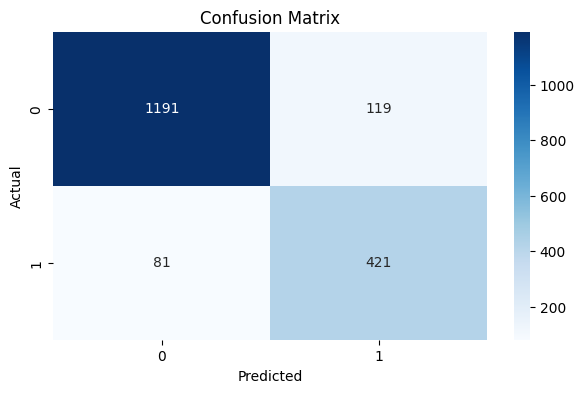

In [88]:
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(7,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Test set predictions

Load the test dataframe, and apply the same preprocessing done for the training set.

In [16]:
df_test = pl.read_csv('Data/Test-Task-2.csv')

encoded_category = df_test['category'].to_dummies()
print(f"test shape: {df_test.shape}")

df_test = pl.concat([df_test, encoded_category], how = 'horizontal')
df_test = df_test.drop(['category_2'])
print(f"test shape: {df_test.shape}")

test shape: (6454, 44)
test shape: (6454, 46)


In [17]:
df_test['client_id'].n_unique()

718

In [18]:
test_df = lagged_table(df_test, 2) 
print(f"test shape: {test_df.shape}")

test shape: (5016, 133)


In [19]:
test_df['client_id'].n_unique()

718

In [20]:
X_test = test_df.select([col for col in test_df.columns if col != 'repays_debt_t+2'])

In [21]:
X_test.shape

(5016, 132)

In [22]:
X_test_filtered = (
    X_test
    .group_by('client_id')
    .agg([
        pl.col('period').max().alias('period')
    ])
    .join(X_test, on=['client_id', 'period'], how='inner')
)

In [23]:
X_test_filtered.shape

(718, 132)

Reorder the columns to ensure consistency, otherwise the scaler won't work.

In [24]:
X_test_filtered = X_test_filtered.select(X.columns)

In [25]:
X_test_filtered.shape

(718, 132)

Apply the Scaler fitted previously.

In [26]:
X_scaled_test = scaler.transform(X_test_filtered)

Compute the probabilities and convert them according to a threshold.

In [27]:
y_pred_test = model.predict_proba(X_scaled_test)[:, 1]

In [28]:
threshold = 0.15
y_pred_test = (y_pred_test > threshold).astype(int)

In [29]:
np.unique(y_pred_test, return_counts = True)

(array([0, 1]), array([421, 297], dtype=int64))

In [30]:
len(y_pred_test)

718

Save the predictions

In [31]:
pd.DataFrame({'Label' : y_pred_test}).to_csv('Predictions/Task2-Threshold015-Lags2-ValData00-IsUnbalance.csv', index = False)